# POTATO LEAF DISEASE CLASSIFICATION
- Based on three classes (Early Blight, Late Blight and Healthy)

## Import all the required modules and dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
import os
import cv2
import numpy as np

# GrabCut
Used for removing background

In [ ]:
def remove_bg_grabcut(img_path):
    image = cv2.imread(img_path)
    mask = np.zeros(image.shape[:2], np.uint8)
    rect = (10, 10, image.shape[1]-20, image.shape[0]-20)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    try:
        cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    except:
        return None
    mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
    img = image * mask2[:, :, np.newaxis]
    return img

In [ ]:
def apply_grabcut_to_folder(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for class_name in os.listdir(input_dir):
        input_class_dir = os.path.join(input_dir, class_name)
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)

        for fname in os.listdir(input_class_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                input_path = os.path.join(input_class_dir, fname)
                output_path = os.path.join(output_class_dir, fname)
                result = remove_bg_grabcut(input_path)
                if result is not None:
                    cv2.imwrite(output_path, result)

In [ ]:
apply_grabcut_to_folder('/content/drive/MyDrive/MCA Sem 1 ML Project/train', '/content/train_grabcut')

## Set the constant values

In [ ]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS = 3

## Import the dataset

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/train_grabcut",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5702 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

## Visualizing some of the images

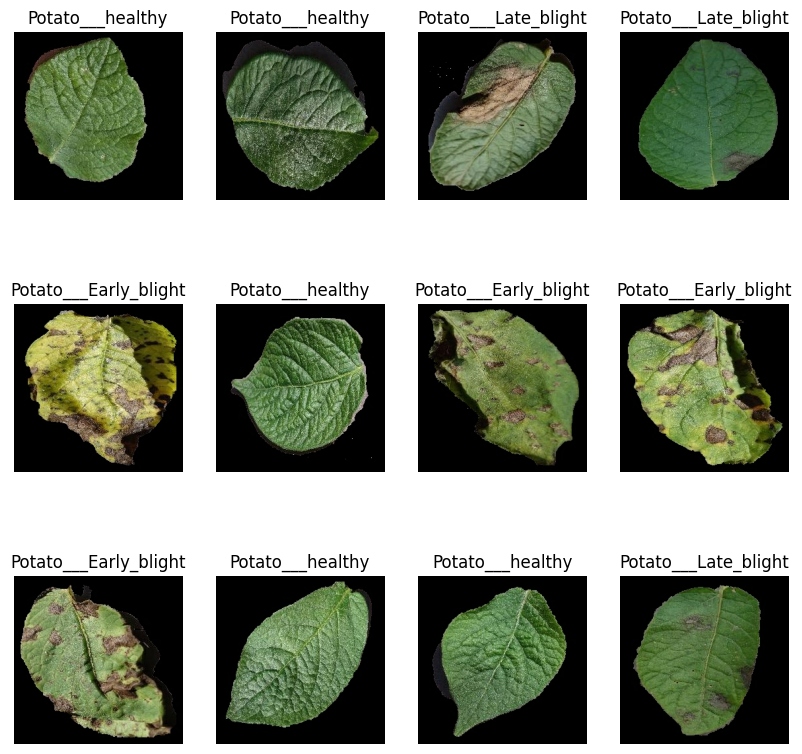

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)


357

## Spliting the Dataset (80-10-10)

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

285

In [ ]:
len(val_ds)

35

In [ ]:
len(test_ds)

37

## Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model


# CNN MODEL ARCHITECTURE
(MobileNetV2)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

<ipython-input-20-19a37b8f40f1>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Compiling the Model
### (Using adam as the optimizer)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
    callbacks=[lr_schedule]
)

Epoch 1/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 290s 912ms/step - accuracy: 0.7198 - loss: 0.6272 - val_accuracy: 0.8732 - val_loss: 0.3264 - learning_rate: 0.0010
Epoch 2/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 250s 876ms/step - accuracy: 0.8758 - loss: 0.3096 - val_accuracy: 0.9179 - val_loss: 0.2289 - learning_rate: 0.0010
Epoch 3/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 259s 909ms/step - accuracy: 0.9004 - loss: 0.2531 - val_accuracy: 0.9018 - val_loss: 0.2526 - learning_rate: 0.0010
Epoch 4/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 248s 870ms/step - accuracy: 0.9230 - loss: 0.2128 - val_accuracy: 0.9179 - val_loss: 0.1978 - learning_rate: 0.0010
Epoch 5/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 264s 925ms/step - accuracy: 0.9324 - loss: 0.1884 - val_accuracy: 0.9339 - val_loss: 0.1758 - learning_rate: 0.0010
Epoch 6/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 245s 862ms/step - accuracy: 0.9366 - loss: 0.1733 - val_accuracy: 0.9268 - val_loss: 0.1815 - learning_rate: 0.0010
Epoch 7/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 279s 921ms/step - accura

In [ ]:
scores = model.evaluate(test_ds)
scores

37/37 ━━━━━━━━━━━━━━━━━━━━ 40s 787ms/step - accuracy: 0.9833 - loss: 0.0642


[0.050790827721357346, 0.9847972989082336]

In [ ]:
accuracy = scores[1]
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 98.48%


### A 98.48% accuracy is achieved using MobileNetV2 Model

# Plotting the Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 285}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

In [ ]:
history.history['accuracy'][:5]

[0.7980219721794128,
 0.8830769062042236,
 0.9024176001548767,
 0.9169231057167053,
 0.9272527694702148]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

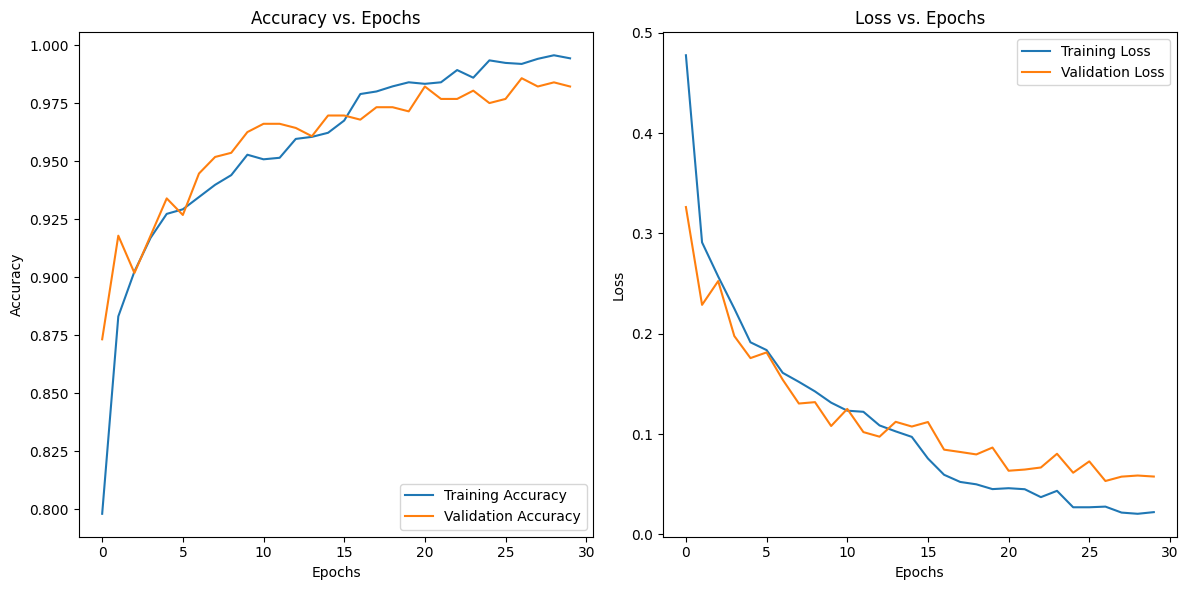

In [ ]:
epochs_range = range(len(acc))
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


## SAVING THE MODEL

In [ ]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('potato_leaf_model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpaojvnyak'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138258169956688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138258169959760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138258169959376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138258169958992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138258169960144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138258169959184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138258169960336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138258169957072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138258169960912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138258169959568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1382581699

In [ ]:
model.save('first_potatoleaf_model.h5')

In [ ]:
model.save('newpotatoCNN_kerasmodel.keras')

In [ ]:
base_model = model.get_layer('mobilenetv2_1.00_224')

# Print all convolutional layers in the base model
for layer in base_model.layers:
    if 'Conv' in layer.name or 'conv' in layer.name:
        print(layer.name)

Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
Conv_1
Conv_1_bn


## LOADING THE SAVED MODEL (FOR CHECKING)

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('newpotatoCNN_kerasmodel.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
scores2 = loaded_model.evaluate(test_ds)
print(f"Loaded Model Test Accuracy: {scores2[1] * 100:.2f}%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 811ms/step - accuracy: 0.9895 - loss: 0.0320
Loaded Model Test Accuracy: 98.48%


## TESTING A SAMPLE IMAGE FROM TEST SPLIT

First image to predict:


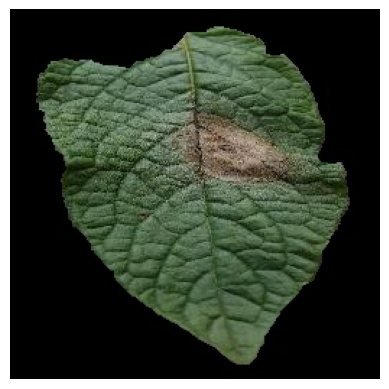

Actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted label: Potato___Late_blight


In [ ]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict:")
    plt.imshow(first_image)
    plt.axis('off')
    plt.show()

    print("Actual label:", class_names[first_label])
    batch_prediction = model.predict(images_batch)
    predicted_label = np.argmax(batch_prediction[0])  # Get the predicted class for the first image
    print("Predicted label:", class_names[predicted_label])

# RUNNING AN INFERENCE OF FEW SAMPLE IMAGES

In [ ]:
def predict(model, img):
    img_array = tf.expand_dims(img, axis=0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


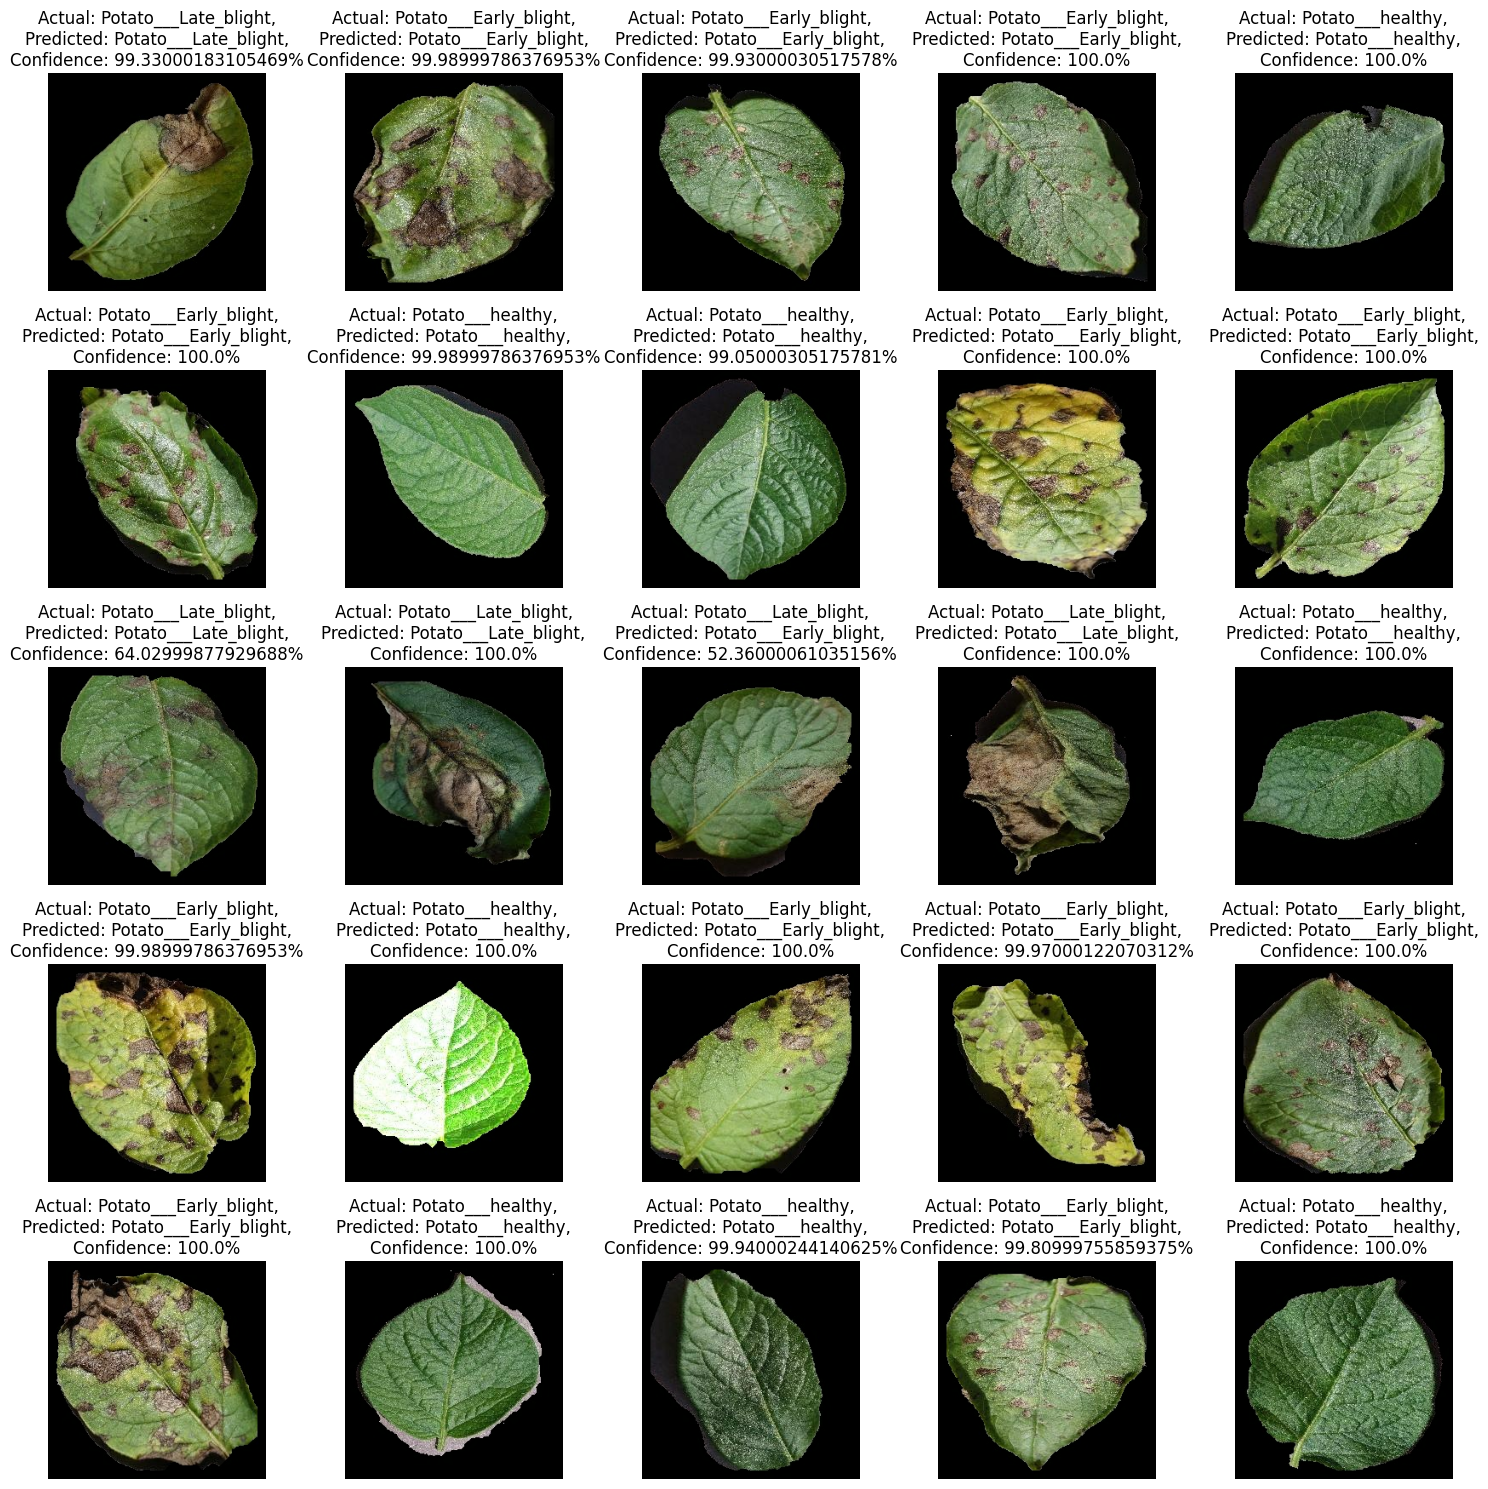

In [ ]:
num_images = 25
rows = int(num_images**0.5)
cols = int(np.ceil(num_images / rows))

plt.figure(figsize=(15, 15))
image_count = 0

for images, labels in test_ds:
    for i in range(len(images)):
        if image_count >= num_images:
            break
        ax = plt.subplot(rows, cols, image_count + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i].numpy()]
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class},\nConfidence: {confidence}%")
        plt.axis("off")
        image_count += 1
    if image_count >= num_images:
        break

plt.tight_layout()
plt.show()

## PLOTTING THE CONFUSION MATRIX
- Diagonal values show correct predictions.
- Off-diagonal values show misclassifications.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━

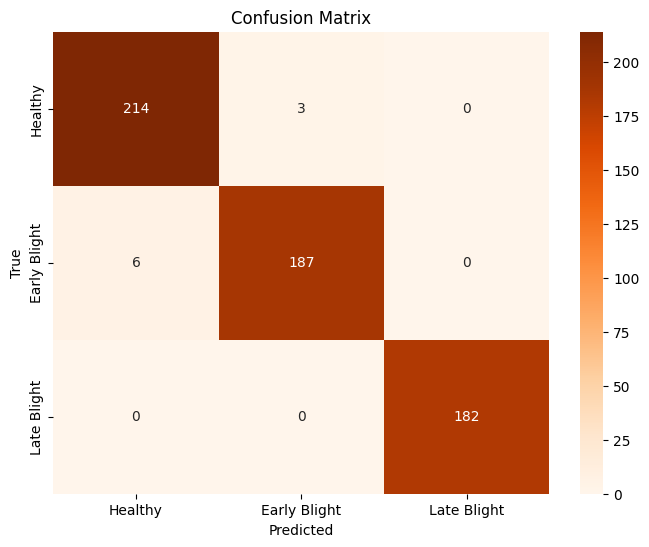

[[214   3   0]
 [  6 187   0]
 [  0   0 182]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       217
           1       0.98      0.97      0.98       193
           2       1.00      1.00      1.00       182

    accuracy                           0.98       592
   macro avg       0.99      0.99      0.99       592
weighted avg       0.98      0.98      0.98       592



In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, precision_recall_curve, accuracy_score, classification_report, confusion_matrix
import seaborn as sns

class_names = ['Healthy', 'Early Blight', 'Late Blight']

true_labels = []
predicted_labels = []

for images, labels in test_ds:
    batch_predictions = model.predict(images)
    predicted_labels_batch = np.argmax(batch_predictions, axis=1)

    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted_labels_batch)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(cm)
print(classification_report(true_labels, predicted_labels))

In [ ]:
!zip -r train_grabcut.zip train_grabcut

Streaming output truncated to the last 5000 lines.
  adding: train_grabcut/Potato___Late_blight/d4463dcb-ae91-4329-8c6d-6da1eecbaaac___RS_LB 2788_180deg.JPG (deflated 6%)
  adding: train_grabcut/Potato___Late_blight/ad628434-32ce-4365-90b0-f394d98fbe00___RS_LB 4905_flipTB.JPG (deflated 7%)
  adding: train_grabcut/Potato___Late_blight/954d36cb-4a20-4889-83dd-4cba7e7180f8___RS_LB 4536_flipTB.JPG (deflated 7%)
  adding: train_grabcut/Potato___Late_blight/3f7f719f-9849-47c5-8f79-0384a64f8e8f___RS_LB 2862.JPG (deflated 6%)
  adding: train_grabcut/Potato___Late_blight/f7438ce7-c12a-40df-83a1-1ab0cde13bb0___RS_LB 3847_180deg.JPG (deflated 5%)
  adding: train_grabcut/Potato___Late_blight/d3cbf715-a2a3-4024-ac5d-c6ae21a77720___RS_LB 2735_flipTB.JPG (deflated 7%)
  adding: train_grabcut/Potato___Late_blight/75fd327f-c30c-4b73-b7a1-fd11aab8206e___RS_LB 2508.JPG (deflated 6%)
  adding: train_grabcut/Potato___Late_blight/0525ac6e-1d1f-4866-89bd-af4b8ba9c46b___RS_LB 4814_180deg.JPG (deflated 7%)
  a

In [ ]:
from google.colab import files
files.download("train_grabcut.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>